## Regularized linear regression

In [27]:
import pandas as pd
import numpy as np


def linear_sol_constrain(x_in, y_in, lamb):
	sudo_inv_x_reg = np.linalg.inv(np.transpose(x_in).dot(x_in) + lamb * np.identity(np.shape(x_in)[1])).dot(np.transpose(x_in))
	weight_reg = sudo_inv_x_reg.dot(y_in)
	return weight_reg

def one_vs_all(tar, train, lamb):
	Y = np.ones(train.shape[0])*-1 # set all to -1
	Y[train.dig == tar] = 1 # Y is the label
	X = train.iloc[0:, 1:] # X is the input
	ones = pd.DataFrame({'const': np.ones(train.shape[0])})
	X = pd.DataFrame.as_matrix(pd.concat([ones, X], axis=1))
	w = linear_sol_constrain(X, Y, lamb)
	return [w, X, Y]

def one_vs_one(tar1, tar2, train, lamb):
	ones = pd.DataFrame({'const': np.ones(train.shape[0])})
	X = train.copy()
	X.insert(1,'const', ones)
	X = X[X['dig'].isin([tar1, tar2])]
	Y = -1*np.ones(X.shape[0])
	Y[X.dig == tar1] = 1 # set up Y
	X = X.iloc[0:, 1:]
	w = linear_sol_constrain(X, Y, lamb)
	return[w, X, Y]

def error_est(x_in, y_in, weight):
	y_in_pred = np.sign(x_in.dot(weight))
	return np.mean(y_in != y_in_pred)

def n_l_transform(data_in):
	data_in_trans = data_in.assign(x3 = np.power(data_in['inten'],2))
	data_in_trans = data_in_trans.assign(x4 = np.power(data_in['symm'],2))
	data_in_trans = data_in_trans.assign(x5 = data_in['inten']*data_in['symm'])
	return data_in_trans

def error_est_out(tar, test_nl, weight):
	X_out = test_nl.iloc[0:,1:]
	ones = ones = pd.DataFrame({'const': np.ones(test_nl.shape[0])})
	X_out.reset_index(drop = True, inplace = True)
	X_out = pd.concat([ones,X_out], axis = 1)
	Y_out = np.ones(test_nl.shape[0])*-1 # set all to -1
	Y_out[test_nl.dig == tar] = 1
	return error_est(X_out, Y_out, weight)

train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
train.columns = ['dig','inten','symm']
test.columns = ['dig','inten','symm']

err = []
for i in range(5,10):
	sol = one_vs_all(i, train, 1)
	w = sol[0]
	X = sol[1]
	Y = sol[2]
	err.append(error_est(X,Y,w))
print(err)

[0.076258400768070222, 0.091071183651076665, 0.088465231106844053, 0.074338225209161987, 0.088328075709779186]


Q7, 8 vs all has the lowest in sample error

In [24]:
train_nl = n_l_transform(train)
test_nl = n_l_transform(test)
err = []
print(train_nl.shape)
for i in range(0,5):
	sol = one_vs_all(i, train_nl, 1)
	w = sol[0]
	X_in = sol[1]
	Y_in = sol[2]
	err.append(error_est_out(i, test_nl, w))
print(err)
    


(7291, 6)
[0.10662680617837568, 0.021923268560039861, 0.098654708520179366, 0.082710513203786751, 0.099651220727453915]


Q8, as shown above, 1 has the lowest out of sample error

In [25]:
err = []
for i in range(0,10):
	sol = one_vs_all(i, train_nl, 1)
	w = sol[0]
	X_in = sol[1]
	Y_in = sol[2]
	err.append(error_est_out(i, test_nl, w))
res = pd.DataFrame({'with trans': np.array(err)})

err = []
for i in range(0,10):
	sol = one_vs_all(i, train, 1)
	w = sol[0]
	X = sol[1]
	Y = sol[2]
	err.append(error_est_out(i, test, w))
res = res.assign(without = np.array(err))
res = res.assign(without_95 = np.array(err)*0.95)

print(res)

   with trans   without  without_95
0    0.106627  0.115097    0.109342
1    0.021923  0.022422    0.021300
2    0.098655  0.098655    0.093722
3    0.082711  0.082711    0.078575
4    0.099651  0.099651    0.094669
5    0.079223  0.079721    0.075735
6    0.084704  0.084704    0.080468
7    0.073244  0.073244    0.069581
8    0.082711  0.082711    0.078575
9    0.088191  0.088191    0.083782


Q9, as shown above, for 5 vs all, transformation improves the performance but less than 5%

In [28]:
sol_transform0 = one_vs_one(1, 5, train_nl, 0.01)
sol_transform1 = one_vs_one(1, 5, train_nl, 1)
err_1 = error_est(sol_transform0[1], sol_transform0[2], sol_transform0[0])
err_2 = error_est(sol_transform1[1], sol_transform1[2], sol_transform1[0])
test_use = test_nl[test_nl['dig'].isin([1,5])]
err_1_out = error_est_out(1, test_use, sol_transform0[0])
err_2_out = error_est_out(1, test_use, sol_transform1[0])
print('in sample error, lambda = 0.01 vs lambda = 1')
print(err_1, err_2)
print('out of sample error, lambda = 0.01 vs lambda = 1')
print(err_1_out, err_2_out)

in sample error, lambda = 0.01 vs lambda = 1
0.00448430493274 0.00512491992313
out of sample error, lambda = 0.01 vs lambda = 1
0.0283018867925 0.0259433962264


Q10, it can be seen that with lambda goes up, $E_{in}$ goes up but $E_{out}$ goes down, meaning that there is an overfitting happening.

## SVM 

[2 3]


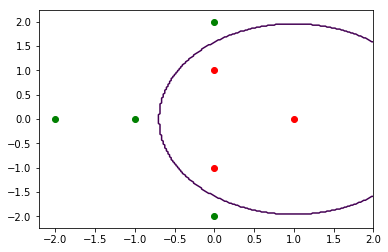

In [2]:
import pandas as pd
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt

indata = pd.DataFrame({'x1': [1,0,0,-1,0,0,-2], 'x2': [0,1,-1,0,2,-2,0],
'y':[-1,-1,-1,1,1,1,1]})
def mykernel(X,Y):
	return (1+np.dot(X,Y.T))**2
clf = svm.SVC(kernel = mykernel, C = np.inf)
clf.fit(indata.loc[:,['x1','x2']], indata.loc[:,'y'])
print(clf.n_support_)
s = plt.figure(1)
plt.scatter(indata[indata.y == -1].loc[:,'x1'],
	indata[indata.y == -1].loc[:,'x2'], color='red')
plt.scatter(indata[indata.y == 1].loc[:,'x1'],
	indata[indata.y == 1].loc[:,'x2'], color='green')
x1 = np.linspace(-2,2,200)
x2 = np.linspace(-2,2,200)
X1,X2 = np.meshgrid(x1,x2)
FX1 = np.ndarray.flatten(X1)
FX2 = np.ndarray.flatten(X2)
M = np.array((FX1,FX2))
F = np.reshape(clf.predict(np.transpose(M)), np.shape(X1))
plt.contour(X1,X2,F,[0])
plt.show()

Q12, as shown above. n_support is 5.

## RBF

In [34]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import sklearn.cluster as clt

def targ_func(X): # X is numpy array organized as [x1,x2]
	y = np.sign(X[:,1] - X[:,0] + 0.25*np.sin(np.pi*X[:,0]))
	return y

def training_set_generate(n):
	training_set = np.random.uniform(-1.0,1.0,[n,2])
	return training_set

c = 0
for i in range(0,10000):
	train = training_set_generate(100)
	y = targ_func(train)
	clf = svm.SVC(C=np.inf, gamma = 1.5, kernel = 'rbf')
	clf.fit(train, y)
	E_in = 1 - clf.score(train, y)
	if(E_in > 0):
		c += 1
print(c/10000)

0.0


Q13, as shown above, svm with RBF kernel can always separate the sample.

0.84


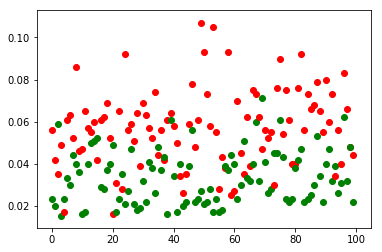

In [35]:
class RBF_regular:
	def __init__(self, K, gamma):
		self.K = K
		self.gamma = gamma
		self.w = None
	def fit(self, train, y):
		# step 1 find the centers
		K = self.K
		gamma = self.gamma
		clust = clt.KMeans(n_clusters = K)
		clust.fit(train)
		centers = clust.cluster_centers_
		# step2 build phi matrix
		phi = np.empty([np.shape(train)[0], K])
		for i in range(0, np.shape(phi)[0]):
			for j in range(0,K):
				phi[i,j] = np.exp(-gamma*np.sum((train[i,]-centers[j,])**2))
		# step3 calculate pseudo inverse
		pseudo = np.linalg.pinv(phi)
		w = np.dot(pseudo, y)
		self.weight = w
		self.centers = centers
	def predict(self, x):
		w = self.weight
		centers = self.centers
		gamma = self.gamma
		K = self.K
		h = 0
		for i in range(0,K):
			h += w[i] * np.exp(-gamma*np.sum((x-centers[i,])**2, axis = 1))
		return np.sign(h)
	def score(self, x, y):
		y_pred = self.predict(x)
		return metrics.accuracy_score(y_pred, y)

c = 0
s = plt.figure(1)
for i in range(0, 100):
	# generate data sets
	train = training_set_generate(100)
	test = training_set_generate(1000)
	y_in = targ_func(train)
	y_out = targ_func(test)
	# svm
	clf = svm.SVC(C=np.inf, gamma = 1.5, kernel = 'rbf')
	clf.fit(train, y_in)
	E_out_svm = 1 - clf.score(test, y_out)
	# rbf regular
	rbf = RBF_regular(9,1.5)
	rbf.fit(train, y_in)
	E_out_rbf = 1 - rbf.score(test, y_out)
	# count the outperform times
	if(E_out_rbf > E_out_svm):
		c += 1
	# plot
	plt.scatter(i,E_out_rbf,c='red')
	plt.scatter(i,E_out_svm,c='green')
print(c/100)
plt.show()

Q14, as shown above, in 100 experiments, 84% of the cases svm performs better than regular rbf method

0.8


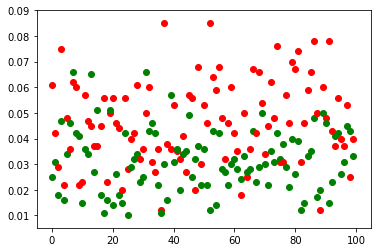

In [36]:
c = 0
s = plt.figure(1)
for i in range(0, 100):
	# generate data sets
	train = training_set_generate(100)
	test = training_set_generate(1000)
	y_in = targ_func(train)
	y_out = targ_func(test)
	# svm
	clf = svm.SVC(C=np.inf, gamma = 1.5, kernel = 'rbf')
	clf.fit(train, y_in)
	E_out_svm = 1 - clf.score(test, y_out)
	# rbf regular
	rbf = RBF_regular(12, 1.5)
	rbf.fit(train, y_in)
	E_out_rbf = 1 - rbf.score(test, y_out)
	# count the outperform times
	if(E_out_rbf > E_out_svm):
		c += 1
	# plot
	plt.scatter(i,E_out_rbf,c='red')
	plt.scatter(i,E_out_svm,c='green')
print(c/100)
plt.show()

Q15, as shown above, increasing the centers will improve the performance of regular rbf cluster. 80% of the experiments svm performs better

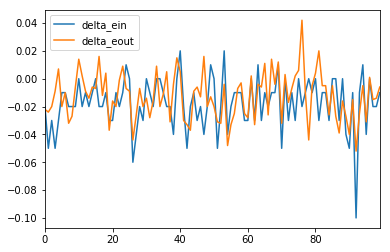

In [37]:
err = pd.DataFrame({'delta_ein': np.empty(100), 'delta_eout': np.empty(100)})
for i in range(0,100):
	train = training_set_generate(100)
	test = training_set_generate(1000)
	y_in = targ_func(train)
	y_out = targ_func(test)
	## cluster
	rbf9 = RBF_regular(9,1.5)
	rbf12 = RBF_regular(12,1.5)
	rbf9.fit(train, y_in)
	rbf12.fit(train, y_in)
	e_in9 = 1-rbf9.score(train, y_in)
	e_in12 = 1-rbf12.score(train, y_in)
	e_out9 = 1-rbf9.score(test, y_out)
	e_out12 = 1-rbf12.score(test, y_out)
	err.iloc[i,0] = e_in12 - e_in9
	err.iloc[i,1] = e_out12 - e_out9
err.plot()
plt.show()

Q16, as shown above, the curves are error_12 - error_9 for in sample and out-of sample errors. Most of the experiments, both delta values are negative meaning that from 9 to 12, both errors will go down.

0.58
0.335


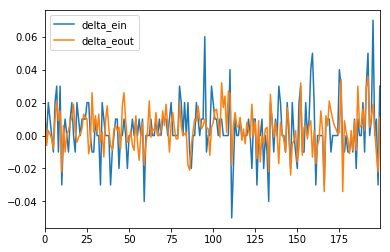

In [38]:
err = pd.DataFrame({'delta_ein': np.empty(200), 'delta_eout': np.empty(200)})
for i in range(0,200):
	train = training_set_generate(100)
	test = training_set_generate(1000)
	y_in = targ_func(train)
	y_out = targ_func(test)
	## cluster
	rbf15 = RBF_regular(9,1.5)
	rbf2 = RBF_regular(9,2)
	rbf15.fit(train, y_in)
	rbf2.fit(train, y_in)
	e_in15 = 1-rbf15.score(train, y_in)
	e_in2 = 1-rbf2.score(train, y_in)
	e_out15 = 1-rbf15.score(test, y_out)
	e_out2 = 1-rbf2.score(test, y_out)
	err.iloc[i,0] = e_in2 - e_in15
	err.iloc[i,1] = e_out2 - e_out15
print(err[err.delta_ein <= 0].shape[0]/200)	
print(err[err.delta_eout <= 0].shape[0]/200)
err.plot()
plt.show()


Q17, as shown above. most of the cases, from gamma = 1.5 to gamma =2, $E_{in}$ will go down while $E_{out}$ will go up, suggesting an overfitting tendency

In [39]:
c = 0
for i in range(0, 1000):
	train = training_set_generate(100)
	y_in = targ_func(train)
	rbf = RBF_regular(9, 1.5)
	rbf.fit(train, y_in)
	score = rbf.score(train, y_in)
	if(score == 1):
		c += 1
print(c/1000)

0.023


Q18, as shown above, only 2% of the time the cluster will reach 0 $E_{in}$

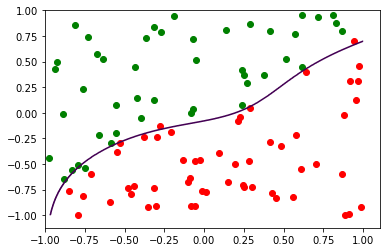

In [43]:
## An example for RBF regular solver
f = plt.figure(0)
train = training_set_generate(100)
y_in = targ_func(train)
plt.scatter(train[y_in == 1,0],train[y_in == 1,1], c = 'green')
plt.scatter(train[y_in == -1,0], train[y_in == -1,1], c= 'red')
rbf = RBF_regular(9, 1.5)
rbf.fit(train, y_in)

x1 = np.linspace(-1,1,1000)
x2 = np.linspace(-1,1,1000)
X1,X2 = np.meshgrid(x1,x2)
FX1 = np.ndarray.flatten(X1)
FX2 = np.ndarray.flatten(X2)
M = np.array((FX1,FX2))
F = np.reshape(rbf.predict(np.transpose(M)), np.shape(X1))
plt.contour(X1,X2,F,[0])
plt.show()

The above code shows an example clustering process by RBF regular method.